In [46]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field

In [47]:
load_dotenv()

model = ChatGoogleGenerativeAI(model = "gemini-2.5-flash")

In [48]:
class Sentiment(BaseModel):
    sentiment : Literal['positive', 'negative'] = Field(description="Sentiment of the review")


In [49]:
class Diagnosis(BaseModel):
    issue_type : Literal['UX', "Performance", "Bug", "Support", "Other"] = Field(description="Category of the issue mentioned in the review")
    tone : Literal["angry", "frustrated", "disapointed", "calm"] = Field(description="The emotional tone expressed by the user")
    urgent : Literal["low", "medium", "high"] = Field(description="How urgent or critica the issue appears to be")

In [50]:
llm = model.with_structured_output(Sentiment)
llm2 = model.with_structured_output(Diagnosis)

In [51]:
prompt = "What is the sentiment of the following review - The product is very helpful"

llm.invoke(prompt)

Sentiment(sentiment='positive')

In [52]:
class ReviewState(TypedDict):
    review : str
    sentiment : Literal['positive', 'negative']
    diagnosis : dict
    response : str 

In [53]:
def find_sent(state : ReviewState):

    prompt = f"What is the sentiment of the following review -{state['review']}"

    sent = llm.invoke(prompt).sentiment

    return {"sentiment" : sent}

In [54]:
def pos_res(state : ReviewState):
    prompt = f"Write a warm thank-you message in response to this review - {state['sentiment']}. Also kindly ask the user to leave feedback on our website."
    mess = model.invoke(prompt).content

    return {"response" : mess}

In [55]:
def diagnosis(state: ReviewState):
    prompt = f"Diagnose this negative review - {state['review']} and return the issue_type, tone and urgency"

    res = llm2.invoke(prompt)

    return {"diagnosis" : res.model_dump()}

In [56]:
def neg_res(state : ReviewState):
    diag = state['diagnosis']
    prompt = f"You are a support assistant. The user had a {diag['issue_type']} issue, sounded {diag['tone']}, and marked urgency as {diag['urgent']}. Write an empethetic, helpful reslution message."
    mess = model.invoke(prompt).content

    return {"response" : mess}

In [57]:
def check_cond(state: ReviewState) -> Literal['pos_res', 'diagnosis']:
    if state['sentiment'] == 'positive':
        return 'pos_res'
    elif state['sentiment'] == 'negative':
        return "diagnosis"

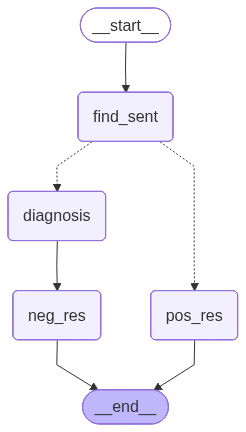

In [58]:
graph = StateGraph(ReviewState)

graph.add_node("find_sent", find_sent)
graph.add_node("pos_res", pos_res)
graph.add_node("neg_res", neg_res)
graph.add_node("diagnosis", diagnosis)

graph.add_edge(START, "find_sent")
graph.add_conditional_edges("find_sent", check_cond)

graph.add_edge("diagnosis", "neg_res")
graph.add_edge("pos_res", END)
graph.add_edge("neg_res", END)

workflow = graph.compile()
workflow

In [59]:
initial_state = {
    "review" : "I honestly regret buying this app. It constantly freezes whenever I try to load my dashboard, and sometimes it doesn’t even save my work properly. I’ve lost hours of progress because of this. The performance is so bad that even simple tasks take forever, and customer support hasn’t responded to my ticket in over a week. This is completely unacceptable for a paid product."
}

workflow.invoke(initial_state)

{'review': 'I honestly regret buying this app. It constantly freezes whenever I try to load my dashboard, and sometimes it doesn’t even save my work properly. I’ve lost hours of progress because of this. The performance is so bad that even simple tasks take forever, and customer support hasn’t responded to my ticket in over a week. This is completely unacceptable for a paid product.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Performance',
  'tone': 'frustrated',
  'urgent': 'high'},
 'response': "Subject: Resolution for Your Urgent Performance Issue - [Your Ticket ID or Reference]\n\nHi [User's Name],\n\nI'm so sorry to hear you've been experiencing a frustrating and urgent performance issue. I understand how incredibly disruptive and stressful that can be, especially when you're trying to get things done, and I truly apologize for the inconvenience this has caused.\n\nI want to assure you that I've received your message and immediately prioritized investigating the perf

In [67]:
initial_state = {
    "review" : "I’ve been really impressed with this app so far. The interface is clean and easy to use, and everything runs smoothly without lag. I especially like how quickly updates are released with new features. Customer support was also very helpful when I had a small question. Overall, it’s been a great experience and definitely worth the price."
}

workflow.invoke(initial_state)

{'review': 'I’ve been really impressed with this app so far. The interface is clean and easy to use, and everything runs smoothly without lag. I especially like how quickly updates are released with new features. Customer support was also very helpful when I had a small question. Overall, it’s been a great experience and definitely worth the price.',
 'sentiment': 'positive',
 'response': 'Here are a few options, choose the one that best fits your brand\'s voice!\n\n**Option 1: Warm & Enthusiastic**\n\n> What a wonderful review to read! Thank you so much for your incredibly kind words and for taking the time to share your positive experience. We\'re absolutely delighted to hear you enjoyed [mention something general like \'our product/service\' or \'your time with us\'] and that we met your expectations.\n>\n> Your feedback truly means the world to our team and serves as a fantastic motivation for us to keep doing our best.\n>\n> If you wouldn\'t mind, we\'d be incredibly grateful if y